In [30]:
import gauleg as gl 
import sympy as sp 
import numpy as np 
import pandas as pd 
import math
import matplotlib.pyplot as plt
np.random.seed(12345)

#####################################
###### INITIALISING PARAMETERS ######
#####################################

# def a0(x):
#     return 2 + math.sin(2*math.pi *x)

# def a0(x):
#     if 0 <= x < xd:
#         return 1
#     elif 0.5 <= x <= 1:
#         return 2

import numpy as np

def a0(x, beta):
    """
    Computes the coefficient a0 at points x using the parameter beta.
    
    Parameters:
        x (array-like): Spatial coordinates.
        beta (tuple): (x_star, r) where x_star is the center of the interval 
                      and r is the half-width of the interval.
    
    Returns:
        np.array: Coefficient values; 2 if x is inside the interval, 1 otherwise.
    """
    x_star, r = beta
    x = np.asarray(x)
    return np.where((x >= (x_star - r)) & (x <= (x_star + r)), 2.0, 1.0)


# def f(x, beta):
#     x = np.asarray(x)
#     return a0(x, beta) * np.pi**2 * np.sin(np.pi * x)
def f(x, beta):
    x = np.asarray(x)
    return np.ones_like(x)

n2 =5

####################################
######### HELPER FUNCTIONS #########
####################################

    
# helper functions
def GL(x_left, x_right, func):
    # Ensure xi and ci are NumPy arrays:
    xi, ci = np.polynomial.legendre.leggauss(n2)
    # Map the nodes from [-1,1] to [x_left, x_right]
    x_mapped = 0.5 * ((x_right - x_left) * xi + (x_right + x_left))
    # Evaluate the integrand at all mapped nodes (func must be vectorized or accept an array)
    integrand_values = func(x_mapped)
    # Compute the weighted sum using a dot-product and return the scaled result.
    return 0.5 * (x_right - x_left) * np.dot(ci, integrand_values)

def piecewise_GL(integrand, x_left, x_right, discont_points=None):
    """
    Integrate 'integrand(x)' from x_left to x_right using Gauss-Legendre quadrature,
    splitting the integration at any discontinuity points provided in discont_points.
    
    Parameters:
      integrand      : function to integrate, which must accept a NumPy array.
      x_left, x_right: the endpoints of the integration interval.
      n2             : number of Gauss–Legendre quadrature points.
      discont_points : a list (or scalar) of discontinuity points in (x_left, x_right).
                       If None or empty, no splitting is performed.
    
    Returns:
      The value of the integral.
    """
    # If no discontinuity is provided, do a single integration.
    if discont_points is None or len(discont_points) == 0:
        return GL(x_left=x_left, x_right=x_right, func=integrand)
    
    # Ensure discont_points is a list; if it's a scalar, convert it.
    if not isinstance(discont_points, (list, tuple, np.ndarray)):
        discont_points = [discont_points]
    
    # Filter out those discontinuity points that lie within (x_left, x_right)
    splits = [p for p in discont_points if x_left < p < x_right]
    
    # Build the list of subinterval endpoints
    pts = [x_left] + sorted(splits) + [x_right]
    
    # Integrate over each subinterval and sum the results.
    total = 0.0
    for i in range(len(pts) - 1):
        total += GL(x_left=pts[i], x_right=pts[i+1], func=integrand)
    return total

def dphi_i_on_element(i, k, xlist):
    """
    Return the (constant) slope of the i-th shape function on the k-th subinterval
    [ x_k, x_{k+1} ] in a 1D mesh with nodes x_0 < ... < x_N.
    """
    if i == k:
        # node i is the left endpoint of the subinterval => slope from 1 at x_k down to 0 at x_{k+1}
        dx = xlist[k+1] - xlist[k]
        return -1.0 / dx
    elif i == k+1:
        # node i is the right endpoint => slope from 0 at x_k up to 1 at x_{k+1}
        dx = xlist[k+1] - xlist[k]
        return +1.0 / dx
    else:
        return 0.0
def phi_i(i, x, mesh):
    """
    Standard 1D hat (finite element) function.
    This returns the value of the i-th hat function at x, given a mesh.
    """
    x = np.asarray(x)  # Ensure x is a NumPy array.
    N = len(mesh) - 1  # Number of elements; nodes are 0,1,...,N.
    
    if i == 0:
        # For the left boundary, phi_0 is nonzero on [mesh[0], mesh[1]]
        cond = (x >= mesh[0]) & (x <= mesh[1])
        return np.where(cond, (mesh[1] - x) / (mesh[1] - mesh[0]), 0.0)
    
    elif i == N:
        # For the right boundary, phi_N is nonzero on [mesh[N-1], mesh[N]]
        cond = (x >= mesh[N-1]) & (x <= mesh[N])
        return np.where(cond, (x - mesh[N-1]) / (mesh[N] - mesh[N-1]), 0.0)
    
    else:
        # For an interior node i, the support is [mesh[i-1], mesh[i+1]]
        cond = (x >= mesh[i-1]) & (x <= mesh[i+1])
        # On the left subinterval [mesh[i-1], mesh[i]]
        left_cond = (x >= mesh[i-1]) & (x <= mesh[i])
        left_val = (x - mesh[i-1]) / (mesh[i] - mesh[i-1])
        # On the right subinterval (mesh[i], mesh[i+1]]
        right_cond = (x > mesh[i]) & (x <= mesh[i+1])
        right_val = (mesh[i+1] - x) / (mesh[i+1] - mesh[i])
        # Combine the two pieces:
        val = np.where(left_cond, left_val, np.where(right_cond, right_val, 0.0))
        return np.where(cond, val, 0.0)


def assemble_nodal_values(C):
    C = np.asarray(C) # Make sure C is 1D.
    return np.concatenate(([[0.0]], C, [[0.0]]))


def get_discont_points(x_left, x_right, beta):
    """
    Compute the discontinuity points for the coefficient a0(x, beta) on the interval [x_left, x_right].

    Parameters:
      x_left, x_right : float
          Endpoints of the integration interval.
      beta : tuple
          (x_star, r), where the discontinuity endpoints are x_star - r and x_star + r.
    
    Returns:
      A list of discontinuity points (subset of [x_star - r, x_star + r]) that lie in (x_left, x_right).
    """
    x_star, r_val = beta
    pts = []
    p1 = x_star - r_val
    p2 = x_star + r_val
    if x_left < p1 < x_right:
        pts.append(p1)
    if x_left < p2 < x_right:
        pts.append(p2)
    return pts


def solve_scF_once(mesh, beta):
    """
    Build and solve the system S*C = F for a single iteration.

    Parameters
    ----------
    n_list, m_list : lists of indices (e.g. polynomial degrees)
    i_list         : indices for the piecewise-constant or piecewise-linear basis

    Returns
    -------
    C : Sympy Matrix
        The solution vector for the unknowns.
    """
    a0_with_beta = lambda x: a0(x, beta)

    S0_mat = S0_ji(a0_with_beta, mesh, beta)         # Possibly a Sympy matrix
    fvect = build_force_vector(f, mesh, 5, beta)  # Possibly a Sympy matrix

    
    # Extract interior (numerical slicing)
    S_int = S0_mat[1:-1, 1:-1]
    F_int = fvect[1:-1, :]
    c_sol = np.linalg.solve(S_int.T, F_int) 

    return c_sol, fvect

def refinement_loop2(beta, num_dorfler):
    """
    1) Start with an initial mesh
    2) Solve once
    3) Estimate errors
    4) Refine if needed, or break if done
    5) Return mesh, solution, and stored data
    """
    ddof_list = []
    approximation_list = []

    # Initial mesh
    mesh = np.linspace(0.0, 1.0, 5).tolist()
    print('length mesh:', len(mesh))
    ddof = len(mesh) - 2

    # We'll collect solution values at these observation points every iteration
    obv_points = np.linspace(0.0, 1.0, 11)
    obs_values_list = []  # will store arrays of length 9 (solution at each obs point)

    iteration_index = 0
    
    while iteration_index < num_dorfler:
        # 1) Solve for c_sol on the current mesh
        c_sol, f_sol = solve_scF_once(mesh=mesh, beta=beta)

        

        # 3) For your "global" approximation (e.g., a scalar measure)
        nodal = assemble_nodal_values(c_sol)

        approximation = nodal.T @ f_sol
        approximation_list.append(approximation)

        # 4) Estimate elementwise errors
        errors = sum_of_error_list(mesh=mesh, nodal=nodal, beta=beta)

        # 5) Mark which elements to refine
        elements_to_refine = dorfler_marking(errors, 0.5)

        if not elements_to_refine:
            # no elements to refine => done
            break
        
        obvs_at_obv_nodes = fe_solution_at_obs(c_sol, mesh, obv_points)
        obs_values_list.append(obvs_at_obv_nodes)
        # Refine the mesh
        new_mesh = element_refinement(mesh, elements_to_refine)


        if new_mesh == mesh:
            print("Mesh did not change upon refinement. Terminating.")
            break

        mesh = new_mesh
        iteration_index += 1

        # Update degrees of freedom (assuming 1D interior points only)
        ddof += len(new_mesh) - 2
        ddof_list.append(ddof)
    c_sol, f_sol = solve_scF_once(mesh=mesh, beta=beta)
    true_obs_values = obs_values_list[-1]  # array of length 9

    # Return what you need
    return (mesh, c_sol, ddof_list, true_obs_values,
            obs_values_list)
def compute_integral_x_dudx(mesh, c_sol):
    c_sol_full = assemble_nodal_values(c_sol)
    total = 0.0
    for e in range(len(mesh)-1):
        x0 = mesh[e]
        x1 = mesh[e+1]
        c0 = c_sol_full[e]
        c1 = c_sol_full[e+1]
        # Slope on element e
        slope_e = (c1 - c0) / (x1 - x0)

        # Contribution from element e
        total += slope_e * (x1**2 - x0**2) * 0.5

    return total



def phi_scalar_parametric(mesh, obs_scalar, sigma):
    """
    Returns a function phi(r) = 0.5/sigma^2 * ( obs_scalar - G(r) )^2
    where G(r) = integral_x_dudx(...) on 'mesh'.
    """
    var = sigma**2

    def phi(r):
        # Solve PDE once for parameter [0.5, r]
        c_sol_r, _ = solve_scF_once(mesh, np.array([0.5, r]))
        # Forward operator = integral of x dudx
        G_r = compute_integral_x_dudx(mesh, c_sol_r)
        print("G(r)_M:", G_r)
        diff = obs_scalar - G_r
        print("Diff_r :", diff)
        return 0.5 * (diff**2) / var

    return phi

def compute_normalising_constant(I, phi_func, num_quad_points):
    r_min, r_max = I
    # Gauss–Legendre nodes & weights on [-1,1]
    xi, w = np.polynomial.legendre.leggauss(num_quad_points)

    # 1) Map nodes to [r_min, r_max]
    xs = 0.5 * ( (r_max - r_min)*xi + (r_max + r_min) )

    # 2) Scale weights
    ws = 0.5 * (r_max - r_min) * w

    # Evaluate the integrand
    integrand_vals = np.exp(-np.array([phi_func(r) for r in xs]))

    # Multiply by uniform prior density on [r_min, r_max]
    prior_density = 1.0 / (r_max - r_min)
    integrand_vals *= prior_density

    # Sum up: \sum f(x_i)*w_i^{(scaled)}
    return np.sum(integrand_vals * ws)

def compute_hellinger_distance(phi_ref, Z_ref, phi_M, Z_M, I, num_quad_points):
    """
    Computes H^2 = 1 - 1/sqrt(Z_ref * Z_M) * \int exp(-0.5[phi_ref(r) + phi_M(r)]) * prior(r) dr
    Then returns H = sqrt(H^2).
    """
    r_min, r_max = I
    xi, ci = np.polynomial.legendre.leggauss(num_quad_points)
    xs = 0.5 * ( (r_max - r_min)*xi + (r_max + r_min) )
    cs = 0.5 * (r_max - r_min) * ci

    # Evaluate 0.5*(phi_ref(r)+phi_M(r)) at each node
    half_sum_vals = []
    for r in xs:
        val = 0.5 * (phi_ref(r) + phi_M(r))
        half_sum_vals.append(val)

    integrand_vals = np.exp(-np.array(half_sum_vals))
    
    # Multiply by uniform prior density on I
    prior_density = 1.0 / (r_max - r_min)
    integrand_vals *= prior_density

    integral_val = np.sum(integrand_vals * cs)
    
    # H^2 = 1 - integral_val / sqrt(Z_ref * Z_M)
    factor = integral_val / np.sqrt(Z_ref * Z_M)
    H2 = 1.0 - factor
    if H2 < 0.0:
        # numerical guard if factor > 1 by tiny rounding
        H2 = 0.0
    H = np.sqrt(H2)
    return H



###################################
####### ASSEMBLY OF MATRIX  #######
###################################

# assembly of matrix S0 and F
def S0_ji(func, mesh, beta):
    """
    Assemble the stiffness matrix S0 using the coefficient function 'func' (which is beta-aware)
    and the mesh. The integration splits at the discontinuity points derived from beta.
    """
    N = len(mesh)
    S0_mat = np.zeros((N, N), dtype=float)

    # Assembly of diagonal entries:
    for j in range(N):
        diag_val = 0.0
        # Contribution from the left subinterval [mesh[j-1], mesh[j]]
        if j > 0:
            x_left = mesh[j-1]
            x_right = mesh[j]
            def integrand_left(x):
                return func(x) * (dphi_i_on_element(j, j-1, mesh))**2
            diag_val += piecewise_GL(integrand_left, x_left, x_right,
                                      discont_points=get_discont_points(x_left, x_right, beta))
        # Contribution from the right subinterval [mesh[j], mesh[j+1]]
        if j < N-1:
            x_left = mesh[j]
            x_right = mesh[j+1]
            def integrand_right(x):
                return func(x) * (dphi_i_on_element(j, j, mesh))**2
            diag_val += piecewise_GL(integrand_right, x_left, x_right,
                                      discont_points=get_discont_points(x_left, x_right, beta))
        S0_mat[j, j] = diag_val

    # Assembly of off-diagonal entries:
    for j in range(1, N):
        x_left = mesh[j-1]
        x_right = mesh[j]
        def integrand_off(x):
            return func(x) * dphi_i_on_element(j-1, j-1, mesh) * dphi_i_on_element(j, j-1, mesh)
        val = piecewise_GL(integrand_off, x_left, x_right,
                           discont_points=get_discont_points(x_left, x_right, beta))
        S0_mat[j, j-1] = val
        S0_mat[j-1, j] = val  # Exploiting symmetry
    
    return S0_mat


def build_force_vector(f, mesh, n2=5, beta=None):
    """
    Assemble the force (load) vector F where
         F[i] = ∫ f(x, beta) * phi_i(x, mesh) dx,
    splitting the integration at the discontinuity points derived from beta.
    
    Parameters:
      f     : The source function, which now depends on beta.
      mesh  : List of node coordinates.
      n2    : Number of Gauss-Legendre points (if used in GL).
      beta  : Parameter tuple (x_star, r) used in f.
      
    Returns:
      F : A column vector (Sympy Matrix) of size (N+1) x 1.
    """
    num_nodes = len(mesh)
    F = np.zeros((num_nodes, 1), dtype=float)

    
    # Loop over each finite element function phi_i.
    for i in range(num_nodes):
        total = 0.0
        # Left subinterval (if it exists)
        if i > 0:
            x_left  = mesh[i-1]
            x_right = mesh[i]
            def integrand_left(x):
                return f(x, beta) * phi_i(i, x, mesh)
            total += piecewise_GL(integrand_left, x_left, x_right,
                                  discont_points=get_discont_points(x_left, x_right, beta))
        # Right subinterval (if it exists)
        if i < num_nodes - 1:
            x_left  = mesh[i]
            x_right = mesh[i+1]
            def integrand_right(x):
                return f(x, beta) * phi_i(i, x, mesh)
            total += piecewise_GL(integrand_right, x_left, x_right,
                                  discont_points=get_discont_points(x_left, x_right, beta))
        
        F[i, 0] = total
    return F


##############################################
####### ERROR INDICATOR AND REFINEMENT #######
##############################################


# def r(mesh, e):
#     """
#     Compute an approximation to the cell residual on element T = [mesh[e], mesh[e+1]].
#     Since u_h is piecewise linear and a0 is constant on T (if T does not cross x=1/3),
#     the derivative term is zero and we approximate r(x) by f(x).
#     """
#     a, b = mesh[e], mesh[e+1]
#     # Use a vectorized quadrature routine to approximate the L2 norm of f over T.
#     rT = GL(a, b, f) / (b - a)
#     return rT

def r(x, mesh, uh, beta):
    # 'uh' and 'mesh' are not strictly needed since a'(x)=0 almost everywhere.
    # The interior PDE says r(x) = f(x) + slope*a'(x), and here r(x) is taken as f(x).
    return f(x, beta)

def element_residual_l2(mesh, e, beta):
    """
    Compute the L2 norm squared of the cell residual on element T = [mesh[e], mesh[e+1]].
    If r(x) is piecewise constant on T, then the L2 norm squared is (r_T)^2 * h.
    When T is cut by a discontinuity, we integrate piecewise.
    """
    a, b = mesh[e], mesh[e+1]
    h = b - a
    
    discont_points = get_discont_points(a, b, beta)
    
    # Define the integrand that includes the dependence on beta.
    def interior_integrand(x_val):
        # Use r(x, ..., beta) so that the effect of beta is incorporated.
        return r(x_val, None, None, beta)**2

    # Integrate using piecewise_GL, splitting at the discontinuities if needed.
    r_sq = piecewise_GL(interior_integrand, x_left=a, x_right=b, discont_points=discont_points)
    return r_sq


def slope_at_node(mesh, uh, i, side):
    """
    Return the slope of the piecewise-linear FE solution uh on the element
    adjacent to node i from the given side ('left' or 'right').
    """
    n = len(mesh) - 1
    if side == 'left':
        if i == 0:
            return 0.0
        else:
            dx = mesh[i] - mesh[i-1]
            return (uh[i] - uh[i-1]) / dx
    elif side == 'right':
        if i >= n:
            return 0.0
        else:
            dx = mesh[i+1] - mesh[i]
            return (uh[i+1] - uh[i]) / dx
    else:
        raise ValueError("side must be 'left' or 'right'.")

def flux_jump(mesh, uh, i, a0_func):
    """
    Compute the jump in the numerical flux at the node mesh[i] (assumed interior).
    The flux is sigma = a0 * (approximate derivative). We define:
      sigma_left  = a0(x_i^-) * slope on [mesh[i-1], mesh[i]],
      sigma_right = a0(x_i^+) * slope on [mesh[i], mesh[i+1]].
    The jump is then: j(x_i) = sigma_right - sigma_left.
    
    Parameters:
      mesh    : array of node coordinates.
      uh      : array of nodal values of the FE solution.
      i       : the index of an interior node.
      a0_func : a function to evaluate a0 at a given x.
    
    Returns:
      float: the flux jump at node i.
    """
    slope_left = slope_at_node(mesh, uh, i, 'left')
    slope_right = slope_at_node(mesh, uh, i, 'right')
    # Use a small perturbation to evaluate a0 on either side.
    a_left  = a0_func(mesh[i] - 1e-9)
    a_right = a0_func(mesh[i] + 1e-9)
    sigma_left  = a_left * slope_left
    sigma_right = a_right * slope_right
    return sigma_right - sigma_left

def sum_of_error(i, mesh, nodal, beta):
    """
    Compute the error indicator for element i.
    It consists of two parts:
      - A residual term: h^2 * (L2 norm squared of the residual on element i).
      - A boundary term: h * (flux jump at the element boundary)^2.
    """
    x_left = mesh[i]
    x_right = mesh[i+1]
    h = x_right - x_left
    # Residual error on the element (incorporating beta)
    residual_sq = element_residual_l2(mesh, i, beta)
    # Flux jump error. Note: pass a lambda that fixes beta in the coefficient function.
    boundary_sq = flux_jump(mesh, nodal, i, lambda x: a0(x, beta)) ** 2
    return h**2 * residual_sq + h * boundary_sq


def sum_of_error_list(mesh, nodal, beta):
    """
    Return the error indicator for each element, given the mesh, nodal values, and beta.
    """
    return [sum_of_error(i, mesh, nodal, beta) for i in range(len(mesh) - 1)]


def refine_mesh(mesh, element_index):
    """
    Refine the element [mesh[element_index], mesh[element_index+1]] by bisection.
    """
    x_left = mesh[element_index]
    x_right = mesh[element_index+1]
    midpoint = 0.5 * (x_left + x_right)
    # Insert the midpoint after mesh[element_index]
    return mesh[:element_index+1] + [midpoint] + mesh[element_index+1:]


def element_selection(errors, epsilon):
    """
    Given an array-like 'errors' (one error per element) and a tolerance epsilon,
    return a list of element indices to refine (sorted in descending order).
    """
    errors = np.asarray(errors)
    print(errors.shape)
    # Find all indices where error exceeds epsilon.
    indices = np.nonzero(errors > epsilon)[0]
    # Sort in descending order so that when refining, index shifts are avoided.
    indices = np.sort(indices)[::-1]
    return indices.tolist()

def dorfler_marking(errors, theta):
    errors = np.asarray(errors).flatten()
    total_error = np.sum(errors)
    sorted_indices = np.argsort(-errors)  # descending order
    cum_sum = np.cumsum(errors[sorted_indices])
    num_marked = np.searchsorted(cum_sum, theta * total_error) + 1
    marked_indices = sorted_indices[:num_marked]
    return marked_indices.tolist()

def element_refinement(mesh, element_indices):
    mesh_arr = np.array(mesh)
    element_indices = np.array(element_indices, dtype=int)
    # Compute midpoints for each marked element.
    midpoints = 0.5 * (mesh_arr[element_indices] + mesh_arr[element_indices + 1]).flatten()
    # Concatenate the original mesh with the new midpoints, then sort.
    new_mesh = np.sort(np.concatenate((mesh_arr, midpoints)))
    return new_mesh.tolist()

def compute_basis_functions_at_x(x, mesh):
    """
    Given an observation point x and the mesh, compute the two nonzero
    finite element basis (hat) functions at x.
    
    Returns:
      k: the index such that x is in [mesh[k], mesh[k+1]]
      psi_left: the value of the basis function associated with mesh[k] at x.
      psi_right: the value of the basis function associated with mesh[k+1] at x.
    """
    mesh = np.asarray(mesh, dtype=float)
    # Find the index k such that x is in [mesh[k], mesh[k+1]]
    k = np.searchsorted(mesh, x) - 1
    k = np.clip(k, 0, len(mesh) - 2)  # ensure k is valid
    
    psi_left = phi_i(k, x, mesh)
    psi_right = phi_i(k+1, x, mesh)
    return k, psi_left, psi_right

def fe_solution_at_obs(c_sol, mesh, x_obs):
    """
    Compute the finite element solution at observation points x_obs,
    given the nodal solution c_sol and the mesh.
    
    Parameters:
      c_sol : array of nodal values (length N)
      mesh  : array of node coordinates (length N)
      x_obs : array of observation points
      
    Returns:
      c_interp: array of interpolated FE solution values at x_obs.
    """
    c_sol_full = assemble_nodal_values(c_sol)
    c_sol_full_array = np.asarray(c_sol_full).flatten()
    c_interp = np.zeros_like(x_obs, dtype=float)
    
    for idx, x in enumerate(x_obs):
        k, psi_left, psi_right = compute_basis_functions_at_x(x, mesh)
        # The solution at x is the weighted average of the two nodal values
        c_interp[idx] = c_sol_full_array[k] * psi_left + c_sol_full_array[k+1] * psi_right
    return c_interp
    


In [31]:
num_quad_points = 20
xi, ci = np.polynomial.legendre.leggauss(num_quad_points)
r_min, r_max = 0.1, 0.4
r_nodes = 0.5 * (xi + 1) * (r_max - r_min) + r_min
beta_ref = np.array([0.5, r_nodes[15]])
I = (0.1, 0.4)  # prior domain  
sigma = 0.01
num_dorfler = 30
num_quad_points = 20
M_list = list(range(2,25))  # refinement levels we want

In [32]:
np.random.seed(123)
final_mesh_ref, c_sol_ref, *_ = refinement_loop2(beta = beta_ref, num_dorfler=num_dorfler)
G_ref = compute_integral_x_dudx(final_mesh_ref, c_sol_ref)
obs_scalar = G_ref + np.random.normal(0.0, 0.001)  # or 0 if no noise

phi_ref = phi_scalar_parametric(final_mesh_ref, obs_scalar, sigma)
z_ref = compute_normalising_constant(I, phi_ref, 20)
print("z_ref:", z_ref)

length mesh: 5
G(r)_M: [-0.08298859]
Diff_r : [0.01437572]
G(r)_M: [-0.08294262]
Diff_r : [0.01432974]
G(r)_M: [-0.08284956]
Diff_r : [0.01423668]
G(r)_M: [-0.08269465]
Diff_r : [0.01408178]
G(r)_M: [-0.08245525]
Diff_r : [0.01384238]
G(r)_M: [-0.08210005]
Diff_r : [0.01348717]
G(r)_M: [-0.0815935]
Diff_r : [0.01298062]
G(r)_M: [-0.08089918]
Diff_r : [0.0122863]
G(r)_M: [-0.07998138]
Diff_r : [0.01136851]
G(r)_M: [-0.07880531]
Diff_r : [0.01019243]
G(r)_M: [-0.07736855]
Diff_r : [0.00875568]
G(r)_M: [-0.07568386]
Diff_r : [0.00707098]
G(r)_M: [-0.07376731]
Diff_r : [0.00515443]
G(r)_M: [-0.07171601]
Diff_r : [0.00310314]
G(r)_M: [-0.06958681]
Diff_r : [0.00097394]
G(r)_M: [-0.06752724]
Diff_r : [-0.00108563]
G(r)_M: [-0.06562617]
Diff_r : [-0.00298671]
G(r)_M: [-0.06402554]
Diff_r : [-0.00458734]
G(r)_M: [-0.06284531]
Diff_r : [-0.00576757]
G(r)_M: [-0.06215867]
Diff_r : [-0.00645421]
z_ref: 13.047669478255383


In [33]:
def compute_integral_x_dudx(mesh, c_sol_full):

    total = 0.0
    for e in range(len(mesh)-1):
        x0 = mesh[e]
        x1 = mesh[e+1]
        c0 = c_sol_full[e]
        c1 = c_sol_full[e+1]
        # Slope on element e
        slope_e = (c1 - c0) / (x1 - x0)

        # Contribution from element e
        total += slope_e * (x1**2 - x0**2) * 0.5

    return total

# def integral_x_dudx(mesh, c_sol, a=0.5, b=0.75):
#     """
#     Computes the integral of x * (du/dx) dx over [a,b],
#     where c_sol is a piecewise-linear FE solution on 'mesh'.
#     """
#     mesh = np.asarray(mesh, dtype=float)
#     c_sol = np.asarray(c_sol, dtype=float)

#     total = 0.0

#     for i in range(len(mesh) - 1):
#         x_left = mesh[i]
#         x_right = mesh[i+1]
        
#         # The derivative is constant on [x_left, x_right]
#         # du/dx = (c_sol[i+1] - c_sol[i]) / (x_right - x_left)
#         dudx = (c_sol[i+1] - c_sol[i]) / (x_right - x_left)

#         # Intersection of [x_left, x_right] with [a, b]
#         int_left = max(a, x_left)
#         int_right = min(b, x_right)

#         if int_right > int_left:
#             # Overlap is [int_left, int_right]
#             # Integral = dudx * \int_{int_left}^{int_right} x dx
#             #          = dudx * [0.5*x^2]_{int_left}^{int_right}
#             val = dudx * (0.5*(int_right**2 - int_left**2))
#             total += val

#     return total

def plot_error_of_integral_x_dudx(param, M_list, l_list, M_ref=30):
    """
    For each M in M_list:
      1) Run refinement_loop2(param, M) => final mesh, solution
      2) Compute I(u_h) = ∫ x (du/dx) dx
      3) Compare to reference I(u_ref) from M_ref refinements
      4) Plot error vs. DoF in log-log scale
    """

    # 1) Reference solution (large refinement)
    mesh_ref, c_sol_ref, ddof_list_ref, _, _ = refinement_loop2(param, num_dorfler)
    # 'assemble_nodal_values' if c_sol_ref is only interior
    c_sol_full_ref = assemble_nodal_values(c_sol_ref)
    print("Length c_sol_full:", len(c_sol_full_ref))
    print("length of mesh+m:", len(mesh_ref))
    ref_val = compute_integral_x_dudx(mesh_ref, c_sol_full_ref)
    #ref_val = integral_x_dudx(mesh_ref, c_sol_full_ref, a = 0.5, b = 0.75)

    # Arrays to store data
    dof_vals = []
    error_vals = []

    # 2) Loop over M in M_list
    for M in M_list:
        mesh_m, c_sol_m, ddof_list_m, _, _ = refinement_loop2(param, M)


        c_sol_full_m = assemble_nodal_values(c_sol_m)
        print("Length c_sol_full:", len(c_sol_full_m))
        print("length of mesh+m:", mesh_m)
        val_m = compute_integral_x_dudx(mesh_m, c_sol_full_m)
        #val_m = integral_x_dudx(mesh_m, c_sol_full_m, a = 0.5, b =0.75)

        # Error vs. reference
        error = abs(val_m - ref_val)
        dof = len(mesh_m) - 2  # in 1D with Dirichlet boundaries

        dof_vals.append(dof)
        error_vals.append(error)


    uniform_dofs = []
    uniform_errors = []
    for l in l_list:
        # a) Build uniform mesh
        uniform_mesh = np.linspace(0.0, 1.0, 2**l + 1)
        # b) Solve PDE once
        c_sol_uniform, f_vec_uniform = solve_scF_once(uniform_mesh, param)
        c_sol_uniform_full = assemble_nodal_values(c_sol_uniform)
        print("length of uniform mesh:", len(uniform_mesh))
        print("length of c sol uniform:", len(c_sol_uniform))
        integral_uniform = compute_integral_x_dudx(uniform_mesh, c_sol_uniform_full)
        #integral_uniform = integral_x_dudx(uniform_mesh, c_sol_uniform_full, a = 0.5, b = 0.75)
        # d) Error
        err_u = abs(integral_uniform - ref_val)
        uniform_errors.append(err_u)

        # e) DoF
        dof_u = len(uniform_mesh) - 2
        uniform_dofs.append(dof_u)

    plt.figure(figsize=(7,5))
    plt.loglog(dof_vals, error_vals, 'o--', label='AFEM')
    plt.loglog(uniform_dofs, uniform_errors, 's--', label='Uniform')

    # Optionally do a best-fit line for each
    # (error ~ C * (DoF)^(-p))
    afem_slope, afem_intercept = np.polyfit(np.log(dof_vals).flatten(), np.log(error_vals).flatten(), 1)
    fit_afem = np.exp(afem_intercept)*np.power(dof_vals, afem_slope)
    plt.loglog(dof_vals, fit_afem, 'k--',
               label=f'AFEM fit slope={afem_slope:.2f}')

    uni_slope, uni_intercept = np.polyfit(np.log(uniform_dofs).flatten(), np.log(uniform_errors).flatten(), 1)
    fit_uni = np.exp(uni_intercept)*np.power(uniform_dofs, uni_slope)
    plt.loglog(uniform_dofs, fit_uni, 'k:',
               label=f'Uniform fit slope={uni_slope:.2f}')

    plt.xlabel('Degrees of Freedom (log scale)')
    plt.ylabel('Error in ∫ x du/dx dx (log scale)')
    plt.title('Error in integral vs. DoF: AFEM vs. Uniform')
    plt.legend()
    plt.grid(True, which='both')
    plt.show()

length mesh: 5
Length c_sol_full: 1948
length of mesh+m: 1948
length mesh: 5
Length c_sol_full: 7
length of mesh+m: [0.0, 0.25, 0.375, 0.5, 0.75, 0.875, 1.0]
length mesh: 5
Length c_sol_full: 9
length of mesh+m: [0.0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1.0]
length mesh: 5
Length c_sol_full: 11
length of mesh+m: [0.0, 0.0625, 0.125, 0.1875, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1.0]
length mesh: 5
Length c_sol_full: 13
length of mesh+m: [0.0, 0.03125, 0.0625, 0.125, 0.1875, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 0.9375, 1.0]
length mesh: 5
Length c_sol_full: 17
length of mesh+m: [0.0, 0.015625, 0.03125, 0.0625, 0.125, 0.1875, 0.25, 0.375, 0.4375, 0.5, 0.625, 0.6875, 0.75, 0.8125, 0.875, 0.9375, 1.0]
length mesh: 5
Length c_sol_full: 21
length of mesh+m: [0.0, 0.0078125, 0.015625, 0.03125, 0.0625, 0.125, 0.15625, 0.1875, 0.25, 0.3125, 0.375, 0.4375, 0.5, 0.625, 0.6875, 0.75, 0.8125, 0.875, 0.90625, 0.9375, 1.0]
length mesh: 5
Length c_sol_full: 25
length of mesh+m: [0.0, 0.00390

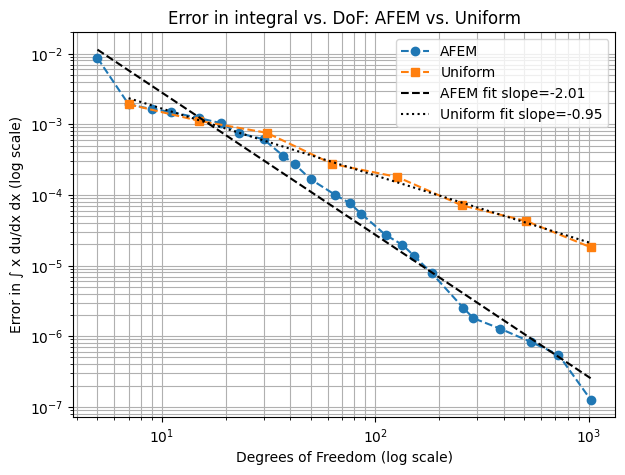

In [34]:
M_list = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16, 17, 18, 20, 21, 22, 24,25, 27]
l_list = [3,4,5,6,7,8,9,10]
plot_error_of_integral_x_dudx(param=beta_ref, M_list=M_list, l_list = l_list, M_ref=30)

In [39]:
r_nodes[15]

np.float64(0.3619497859690226)